In [3]:
import numpy as np
from fish.image.zds import ZDS
from fish.image.alignment import SYNreg
from fish.image.vol import dff
from skimage.io import imread
from skimage.transform import downscale_local_mean as downscale
from fish.util.plot import proj_fuse
import matplotlib.pyplot as plt
from dask.delayed import delayed
import flika as flk
flk.start_flika()

Starting flika


/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Starting flika inside IPython


In [4]:
class opto_exp(object):    
    def __init__(self, raw_path, ephys_path, ds_xy, first_trial):
        from fish.image.zds import ZDS
        from fish.image.vol import unfilter_flat
        from skimage.io import imread        
        from functools import partial
        import numpy as np
        from glob import glob
        from fish.ephys.ephys import load
        from dask.array import from_delayed

        self.paths = {}
        self.paths['raw'] = raw_path
        self.paths['proc'] = self.paths['raw'].replace('raw','proc')
        self.paths['opto'] = self.paths['proc'] + 'opto/'
        self.paths['reg'] = self.paths['proc'] + 'reg/'        
        self.paths['ephys'] = ephys_path
        
        self.dset = ZDS(self.paths['raw'])
        self.ephys = load(self.paths['ephys'])                        
        self.ds_xy = ds_xy
        self.mask = imread(self.paths['opto'] + 'mask.tif').astype('bool')
        self.mask_ds = self.mask[:, ::self.ds_xy, ::self.ds_xy]
        self.recon = partial(unfilter_flat, mask=self.mask_ds)
        self.av_window = np.load(self.paths['opto'] + 'av_window.npy')
        
        self.cond_paths = sorted(glob(self.paths['opto'] + 'condition*'))
        self.conds = [int(c.split('_')[-1]) for c in self.cond_paths]
        
        self.tr_fnames = [sorted(glob(c + '/t_*.npy')) for c in self.cond_paths]
        self.first_trial = first_trial
        self.num_trials = [len(trf) // len(self.av_window) - first_trial for trf in self.tr_fnames]
        self.trial_data = []

        self.trial_medians = [from_delayed(delayed(imread)(f), shape=(len(self.av_window), *self.mask_ds.shape), dtype='float32') for f in sorted(glob(self.paths['opto'] + 'trial_median_condition_*.tif'))] 
                             
        for trf in self.tr_fnames:
            new_shape = len(trf) // len(self.av_window),len(self.av_window), -1
            self.trial_data.append(delayed_npy(trf).reshape(new_shape))
        
    def __repr__(self):
        return self.dset.exp_name
        
def delayed_npy(fnames):
    from numpy import load
    from glob import glob
    from dask.delayed import delayed
    import dask.array as da
    
    delayed_loads = [delayed(np.load)(f) for f in fnames]
    sample = delayed_loads[0].compute()
    result = da.stack([da.from_delayed(d, shape=sample.shape, dtype=sample.dtype) for d in delayed_loads])
    return result

def mask_to_masked_inds(full_mask, recon, partial_mask):
    coords = np.arange(len(np.where(full_mask.ravel())[0]))
    inds = recon(coords).ravel()[partial_mask.ravel()].astype('int')
    return inds

In [5]:
raw_paths= ('/groups/ahrens/ahrenslab/davis/data/spim/raw/20180314/f1/5dpf_gfap_h2b_gcamp_x_huc_rgeco_x_ec43_opto_1_20180314_124124/',
            '/groups/ahrens/ahrenslab/davis/data/spim/raw/20180314/f1/5dpf_gfap_h2b_gcamp_x_huc_rgeco_x_ec43_opto_2_20180314_161038/',
            '/nrs/ahrens/davis/data/spim/raw/20180321/f1/5dpf_ec43xcy331xcy171_f1_opto_1_20180321_115401/',
            '/nrs/ahrens/davis/data/spim/raw/20180321/f1/5dpf_ec43xcy331xcy171_f1_opto_2_20180321_162917/',
           '/nrs/ahrens/davis/data/spim/raw/20180321/f2/5dpf_ec43xcy331xcy171_f2_opto_1_20180321_180812/',
           '/nrs/ahrens/davis/data/spim/raw/20180321/f2/5dpf_ec43xcy331xcy171_f2_opto_2_20180321_212747/',
           '/nrs/ahrens/davis/data/spim/raw/20180328/5dpf_ec43xcy171xcy331_f1_opto_1_20180328_205506/',
           '/nrs/ahrens/davis/data/spim/raw/20180328/5dpf_ec43xcy171xcy331_f1_opto_2_20180328_232414/',
           '/nrs/ahrens/davis/data/spim/raw/20180406/7dpf_ec43xcy171xcy331_opto_1_20180406_121139/',
           '/nrs/ahrens/davis/data/spim/raw/20180406/7dpf_ec43xcy171xcy331_opto_2_20180406_144001/')

ephys_paths = ('/groups/ahrens/ahrenslab/davis/data/ephys/20180314/5dpf_gfap_h2b_gcamp_x_huc_rgeco_x_ec43_opto_1.10chFlt',
               '/groups/ahrens/ahrenslab/davis/data/ephys/20180314/5dpf_gfap_h2b_gcamp_x_huc_rgeco_x_ec43_opto_2.10chFlt',
               '/groups/ahrens/ahrenslab/davis/data/ephys/20180321/f1/5dpf_ec43xcy331xcy171_f1_opto_1.10chFlt',
               '/groups/ahrens/ahrenslab/davis/data/ephys/20180321/f1/5dpf_ec43xcy331xcy171_f1_opto_1.10chFlt',
               '/groups/ahrens/ahrenslab/davis/data/ephys/20180321/f2/5dpf_ec43xcy331xcy171_f2_opto_1.10chFlt',
               '/groups/ahrens/ahrenslab/davis/data/ephys/20180321/f2/5dpf_ec43xcy331xcy171_f2_opto_2.10chFlt',
              '/groups/ahrens/ahrenslab/davis/data/ephys/20180328/5dpf_ec43xcy171xcy331_opto_1.10chFlt',
              '/groups/ahrens/ahrenslab/davis/data/ephys/20180328/5dpf_ec43xcy171xcy331_opto_2.10chFlt',
              '/groups/ahrens/ahrenslab/davis/data/ephys/20180406/7dpf_ec43xcy171xcy331_opto_1.10chFlt',
              '/groups/ahrens/ahrenslab/davis/data/ephys/20180406/7dpf_ec43xcy171xcy331_opto_2.10chFlt')

exps = [opto_exp(*z, ds_xy=2, first_trial=2) for z in zip(raw_paths, ephys_paths)]
fish = np.array(exps).reshape(-1, 2)

group_output = '/groups/ahrens/ahrenslab/davis/data/spim/group/opto-glia-ablate/'

from pickle import load
trms = []
warpers = []
condition = 1
for fi in fish:
    with open(fi[0].paths['reg'] + 'synreg.pickle', 'rb') as f:
            warpers.append(load(f))     

In [13]:
%%time
import numpy as np
from numpy.linalg import inv
from functools import partial
from fish.util.plot import proj_fuse
from skimage.io import imsave
cond = 1
results = []

shrinker = partial(downscale, factors=(1,1,2,2))

for ind, curf in enumerate(fish):
    trm_ = [f.trial_medians[cond].astype('float32').compute() for f in curf]
    warper = warpers[ind]
    g2w = warper.domain_grid2world.copy()
    g2w[1,1] = curf[1].ds_xy
    g2w[2,2] = curf[1].ds_xy
        
    out_shape = trm_[0].shape[1:] 
    lazywarp = delayed(partial(warper.transform, image_world2grid=inv(g2w), out_shape=out_shape, out_grid2world=g2w))
    warped = np.array(delayed([lazywarp(t) for t in trm_[1]]).compute())
    xr = range(min([x.shape[0] for x in trm_]))
    diff = trm_[0][xr] - warped[xr].copy()
    #aspect = (int(curf[0].dset.metadata['z_step'] / (.40625 * curf[0].ds_xy)), 1, 1)
    #pf_max = np.array([proj_fuse(d, np.max, aspect=aspect, arrangement=[2,0,1]) for d in diff])
    #pf_min = -np.array([proj_fuse(d, np.min, aspect=aspect, arrangement=[2,0,1]) for d in diff])
    #tmp = np.hstack([pf_max, pf_min]).astype('float32')        
    imsave(group_output + curf[0].dset.exp_name + '_trial_median_condition_{0}.tif'.format(cond), shrinker(trm_[0][xr]), imagej=True)
    imsave(group_output + curf[1].dset.exp_name + '_trial_median_condition_{0}_warped.tif'.format(cond), shrinker(warped[xr]), imagej=True)
    imsave(group_output + curf[0].dset.exp_name + '_pre_post_ablate_condition_{0}.tif'.format(cond), shrinker(diff), imagej=True)
    del diff, trm_

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /groups/ahrens/ahrenslab/davis/data/spim/group/opto-glia-ablate/5dpf_ec43xcy331xcy171_f1_opto_1_20180321_115401_trial_median_condition_1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /groups/ahrens/ahrenslab/davis/data/spim/group/opto-glia-ablate/5dpf_ec43xcy331xcy171_f1_opto_2_20180321_162917_trial_median_condition_1_warped.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /groups/ahrens/ahrenslab/davis/data/spim/group/opto-glia-ablate/5dpf_ec43xcy331xcy171_f1_opto_1_20180321_115401_pre_post_ablate_condition_1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/groups/ahrens/home/bennettd/anaconda3/lib/python3.

CPU times: user 23min 56s, sys: 12min 42s, total: 36min 38s
Wall time: 10min 2s


In [77]:
[flk.window.Window(result, name=fish[ind][0].dset.exp_name) for ind, result in enumerate(results)]

Closing flika


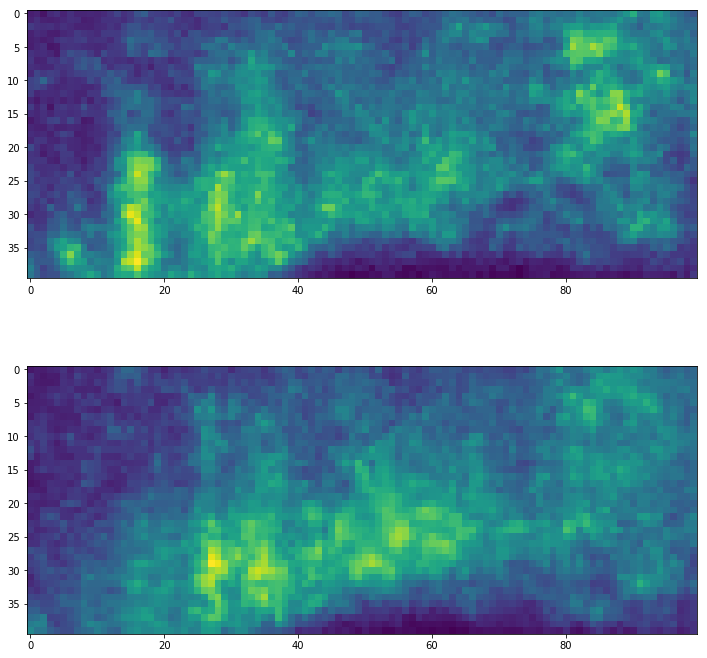

In [12]:
z = 25
fig, axs = plt.subplots(nrows=2, figsize=(12,12))
roi = slice(z, z + 1), slice(360, 400), slice(550, 650)
axs[0].imshow(trm_v[0].max(0)[roi].max(0))
axs[1].imshow(trm_v[1].max(0)[roi].max(0))

## Generate pre- and post-maps with ICA

In [41]:
try:
    ica = np.load(exps[1].paths['opto'] + 'ica_condition_1.npy')
except FileNotFoundError:
    ica = np.load(exps[1].paths['opto'] + 'ica_condition_1.npz')
    ica = ica['weights'], ica['comps']

In [42]:
# figure out which component is the waist neuropil
tmp_v = np.array([(exps[1].recon(ica[0][:,cmp])**2).max(0) for cmp in range(ica[0].shape[1])])

In [55]:
flk.window.Window(exps[1].recon(ica[0][:,58]))

In [51]:
import flika as flk
flk.start_flika()
flk.window.Window(tmp_v)

Starting flika
flika menubar already initialized.
Starting flika inside IPython


In [49]:
from skimage.morphology import binary_opening, ball

labels = dict(pre='pre ablation', post= 'post ablation')
#cmp = 68
cmp = 32
stim_dur = 3.0
condition = 1
cmp_weights = exps[1].recon(ica[0][:,cmp])

# which experiment needs the warped mask
warp_exp = 0
raw_exp = (1,0)[warp_exp]

msks = cmp_weights < np.percentile(cmp_weights, 5), cmp_weights > np.percentile(cmp_weights, 96)
msks = [binary_opening(msk, ball(1)) for msk in msks]
from functools import partial
if warp_exp == 0:
    # go from brain 1 to brain 0
    warp_fun = partial(warper.transform, image_world2grid=inv(g2w), out_shape=msks[0].shape, out_grid2world=g2w)
elif warp_exp == 1:
    # go from brain 0 to brain 1
    warp_fun = partial(warper.transform_inverse, image_world2grid=inv(g2w), out_shape=msks[0].shape, out_grid2world=g2w)

msks_warped = [warp_fun(msk).astype('bool') for msk in msks]

def get_masked_mean(exp, mask, condition):
    msk_inds = mask_to_masked_inds(exp.mask_ds, exp.recon, mask)
    return exp.trial_data[condition][:,:,msk_inds].mean(2).compute()
 
ts_warped = [get_masked_mean(exps[warp_exp], msk_w, 1) for msk_w in msks_warped]
ts_raw = [get_masked_mean(exps[raw_exp], msk_r, 1) for msk_r in msks]

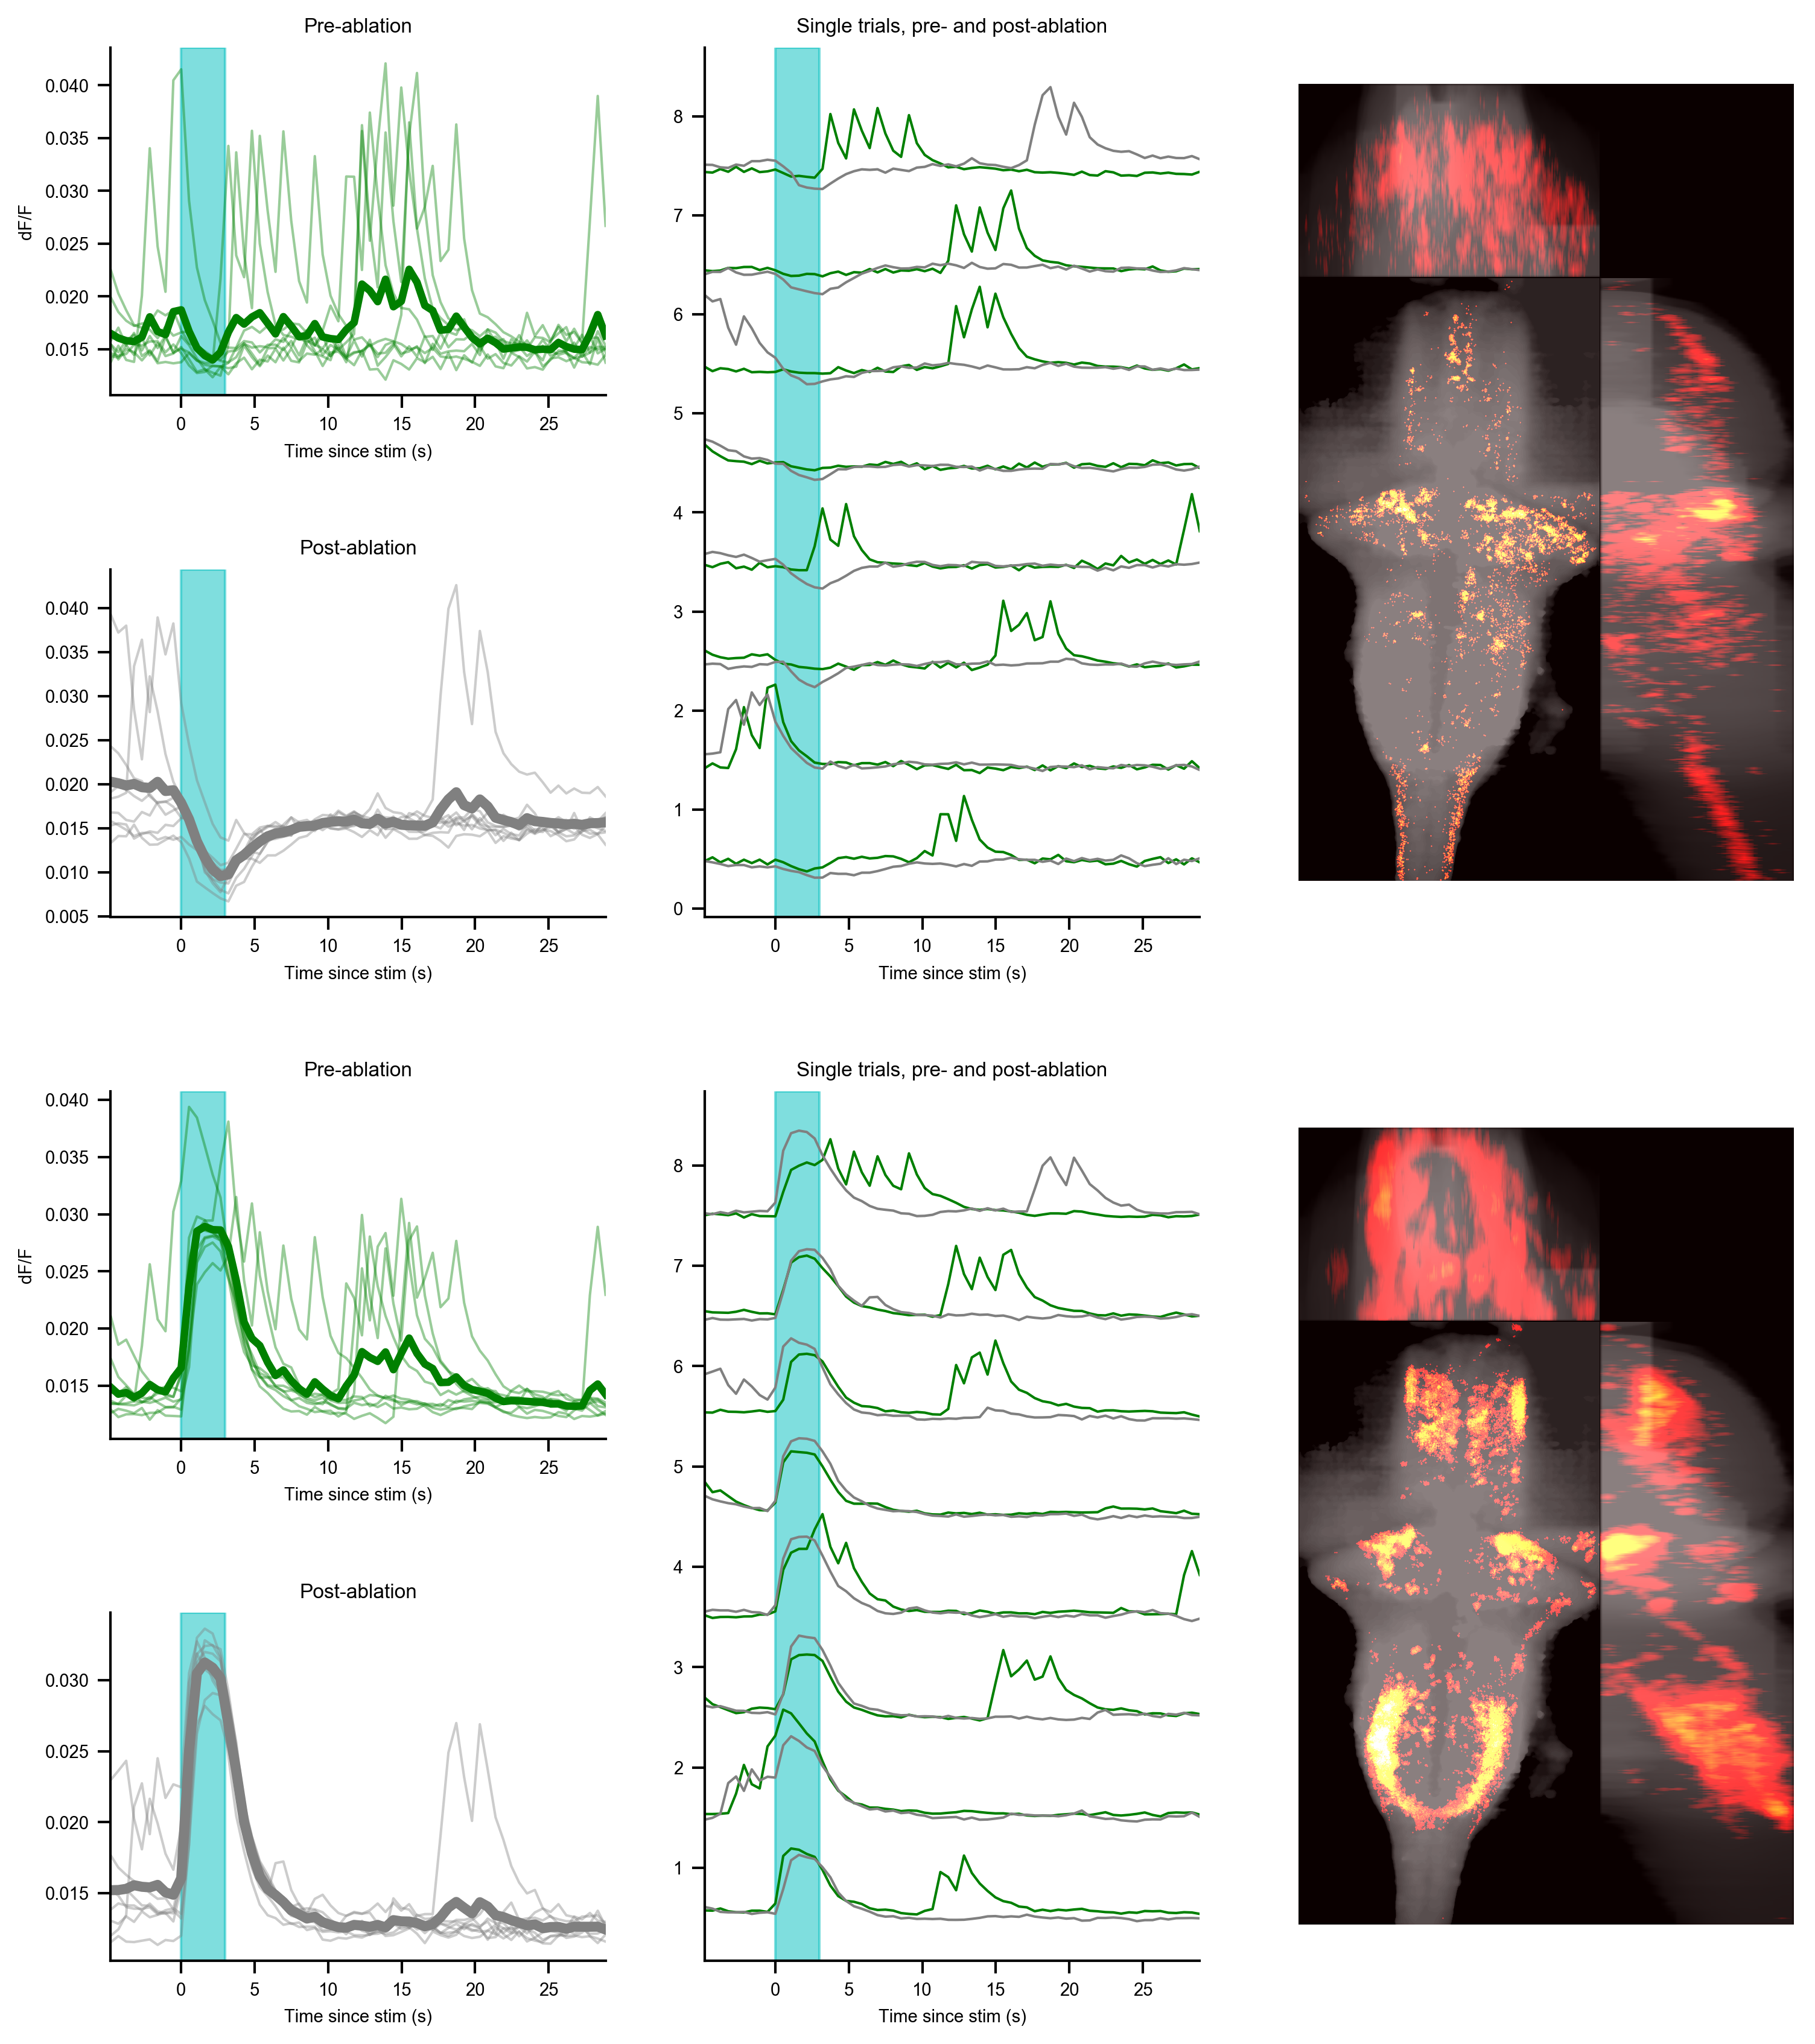

In [50]:
fig = plt.figure(figsize=(12,14), dpi=300)
import matplotlib.gridspec as gridspec
from matplotlib import cm
plt.style.use('npg')
from skimage.exposure import rescale_intensity
from functools import partial
gs = gridspec.GridSpec(nrows=2 * len(msks), ncols=3, hspace=.5)
resc = partial(rescale_intensity, out_range=(0,1))

xr = range(min([len(e.av_window) for e in exps]))
xax = exps[0].av_window[xr] / exps[0].dset.metadata['volume_rate']

if warp_exp == 0:
    ts_pre = ts_warped
    ts_post = ts_raw
else:
    ts_pre = ts_raw
    ts_post = ts_warped
    
for ind in range(len(msks)):        
    cols = ['g', 'gray']
    slc = slice(2* ind, 2 * ind + 2)
    aspect=(8,1,1)
    
    xlabel = 'Time since stim (s)'
    
    proj_msk = cm.hot(resc(proj_fuse(msks[ind], np.mean, aspect=aspect, arrangement=[2,0,1]).transpose(1,0))**.5) 
    anat = cm.gray(resc(proj_fuse(exps[raw_exp].mask_ds, np.mean, aspect=aspect, arrangement=[2,0,1]).transpose(1,0)))
    anat *= np.array([.5,.5,.5,1])
    ax_ts_trial = fig.add_subplot(gs[slc, 1])
    ax_ts_mean = fig.add_subplot(gs[2 * ind, 0]), fig.add_subplot(gs[2 * ind+1, 0])
    ax_im = fig.add_subplot(gs[slc, -1])
    
    scale = 1/(.5 * ts_pre[ind].ptp() + .5 * ts_post[ind].ptp())
    
    ax_ts_trial.plot(xax, np.arange(ts_pre[ind].shape[0]) + scale * ts_pre[ind].T[xr], label=labels['pre'], color=cols[0])
    ax_ts_trial.plot(xax, np.arange(ts_post[ind].shape[0]) + scale * ts_post[ind].T[xr], label=labels['post'], color=cols[1])
    ax_ts_trial.title.set_text('Single trials, pre- and post-ablation')
    ax_ts_trial.set_xlabel(xlabel)
    
    ax_im.imshow((proj_msk + anat).clip(0,1))    
    ax_im.axis('off')
    
    ax_ts_mean[0].plot(xax, ts_pre[ind].T[xr], color=cols[0], alpha=.4)
    ax_ts_mean[0].plot(xax, ts_pre[ind].mean(0)[xr], color=cols[0], linewidth=3)
    ax_ts_mean[0].title.set_text('Pre-ablation')
    ax_ts_mean[0].set_ylabel('dF/F')
    ax_ts_mean[1].plot(xax, ts_post[ind].T[xr], color=cols[1], alpha=.4)
    ax_ts_mean[1].plot(xax, ts_post[ind].mean(0)[xr], color=cols[1], linewidth=4) 
    ax_ts_mean[1].title.set_text('Post-ablation')
    
    [ax.axvspan(0, stim_dur, alpha=.5, color='c') for ax in (ax_ts_trial, *ax_ts_mean)]
    [ax.set_xlabel(xlabel) for ax in (ax_ts_trial, *ax_ts_mean)]
    [ax.set_xlim(xax[0], xax[-1]) for ax in (ax_ts_trial, *ax_ts_mean)]

#plt.savefig(exps[0].paths['opto'] + '{0}_waist_stim_summary.pdf'.format(exps[0].dset.exp_name), dpi=400)